### 고차원 정보를 저차원으로 변환하면서 필요한 정보를 보존하는 것이 임베딩

- mkdir -p ~/aiffel/face_embedding
- ln -s ~/data ~/aiffel/face_embedding/images

file_list: ['reagan.jpg', 'clinton.jpeg', 'trump.jpg', 'biden.jpg', 'bush.jpeg', 'obama.jpg']


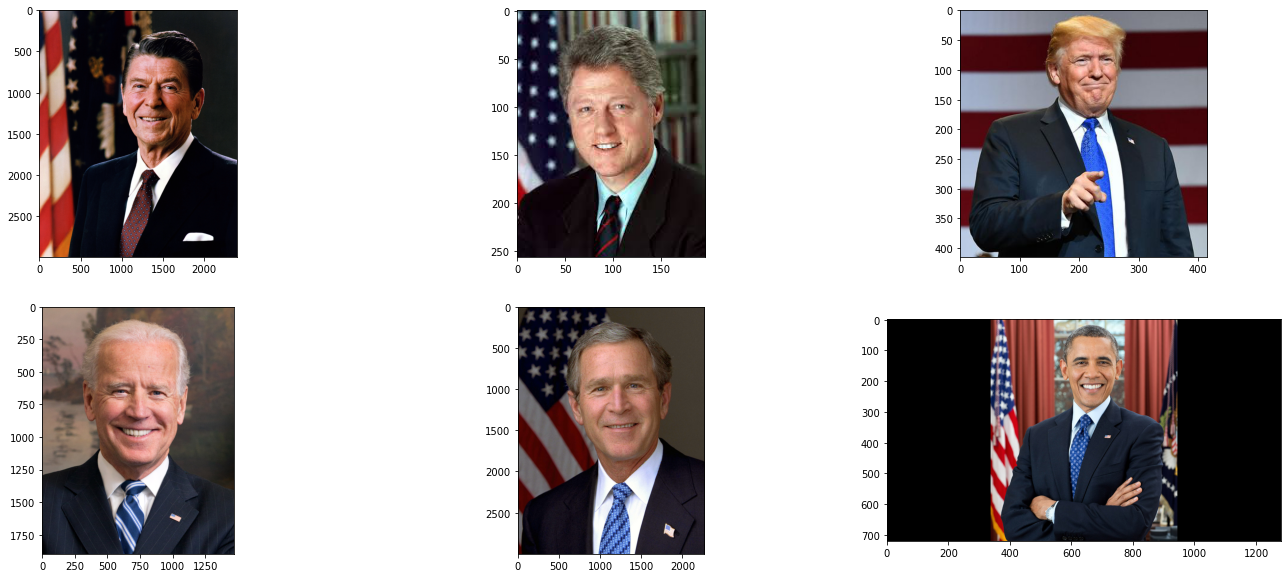

In [1]:
import os

dir_path = os.getenv('HOME')+'/aiffel/face_embedding/images'
file_list = os.listdir(dir_path)

print ("file_list: {}".format(file_list))

import matplotlib.pyplot as plt
import matplotlib.image as img

#Set figsize here
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24,10))

# flatten axes for easy iterating
for i, ax in enumerate(axes.flatten()):
    image = img.imread(dir_path+'/'+file_list[i])
    ax.imshow(image)
plt.show()

fig.tight_layout()

[(98, 758, 284, 572)]


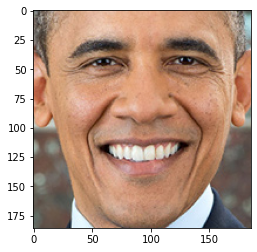

In [2]:
import face_recognition
import os
%matplotlib inline
import matplotlib.pyplot as plt

image_path = os.getenv('HOME')+'/aiffel/face_embedding/images/obama.jpg'
image = face_recognition.load_image_file(image_path)
face_locations = face_recognition.face_locations(image)

print(face_locations)  # 이미지에서 얼굴 영역의 좌표를 출력합니다.

a, b, c, d = face_locations[0]
cropped_face = image[a:c,d:b,:]

plt.imshow(cropped_face)   # 이미지에서 얼굴영역만 잘라낸 cropped_face를 그려 봅니다.

### 이미지 파일 경로를 파라미터로 넘기면 얼굴 영역만 잘라서 뿌려주는 함수

In [4]:
import face_recognition
import os

def get_cropped_face(image_file):
    image = face_recognition.load_image_file(image_file)
    face_locations = face_recognition.face_locations(image)
    a, b, c, d = face_locations[0]
    cropped_face = image[a:c,d:b,:]
    
    return cropped_face

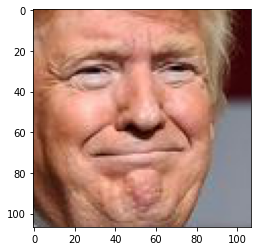

In [5]:
image_path = os.getenv('HOME')+'/aiffel/face_embedding/images/trump.jpg'

cropped_face = get_cropped_face(image_path)
plt.imshow(cropped_face)

얼굴의 특징을 추출해서 적은 차원의 벡터로 만들기 위해서 딥러닝을 사용합니다.\
그렇다면 딥러닝 모델이 얼굴의 특징을 잘 비교할 수 있는 모델이 되도록 학습하려면 어떻게 해야 할까요?

FaceNet은 네트워크 뒤에 L2 Normalization을 거쳐 임베딩을 만들어 내고 여기에 Triplet Loss를 사용

In [22]:
import os

dir_path = os.getenv('HOME')+'/aiffel/face_embedding/images'
file_list = os.listdir(dir_path)

print ("file_list: {}".format(file_list))

file_list: ['reagan.jpg', 'clinton.jpeg', 'trump.jpg', 'biden.jpg', 'bush.jpeg', 'obama.jpg']


In [7]:
image_file = os.path.join(dir_path, 'obama.jpg')
face = get_cropped_face(image_file)   # 얼굴 영역을 구하는 함수(이전 스텝에서 구현)

# 얼굴 영역을 가지고 얼굴 임베딩 벡터를 구하는 함수
def get_face_embedding(face):
    return face_recognition.face_encodings(face)

embedding = get_face_embedding(face)  
embedding

[array([-0.08126248,  0.11014761, -0.01082448, -0.05268792,  0.01033717,
        -0.00813808, -0.07251769, -0.0922646 ,  0.19304723, -0.09246384,
         0.23908533,  0.06770287, -0.22123125, -0.14119367,  0.05562152,
         0.13705511, -0.17924425, -0.07232306, -0.11183281, -0.11370818,
         0.03956435, -0.01019115,  0.0942178 ,  0.04493114, -0.12757549,
        -0.34449592, -0.05374938, -0.17703305,  0.00868226, -0.09721592,
        -0.09817187,  0.00278232, -0.17721367, -0.12789807,  0.03489833,
        -0.01991234, -0.00838933, -0.00132862,  0.18308581,  0.02447568,
        -0.1237656 ,  0.09957044,  0.02323568,  0.22983313,  0.2838524 ,
         0.06655717, -0.00558912, -0.09833544,  0.10058986, -0.23476946,
         0.06006292,  0.1341591 ,  0.08373027,  0.03900504,  0.10194533,
        -0.19337648,  0.01717628,  0.08978969, -0.16005114,  0.01892098,
         0.03082444, -0.06051281, -0.04526773,  0.04633342,  0.20678686,
         0.10299795, -0.12437531, -0.0490516 ,  0.1

images 디렉토리 안에 있는 모든 이미지 파일의 임베딩을 구해서 dict 구조에 담아 리턴하는 함수를 하나 만들어 봅시다.\
딕셔너리의 각 엘리먼트는 \<사람 이름:임베딩벡터>로 하겠습니다.\
함수 이름은 get_face_embedding_dict(dir_path)이고, 다음과 같이 사용하고 싶은 것

- embedding_dict = get_face_embedding_dict(dir_path)
- embedding_dict['obama']  # obama.jpg의 얼굴임베딩 벡터

In [153]:
def get_face_embedding_dict(dir_path):
    file_list = os.listdir(dir_path)
    if '.ipynb_checkpoints' in file_list:
        file_list.remove('.ipynb_checkpoints')
    embedding_dict = {}
    
    for file in file_list:
        img_path = os.path.join(dir_path, file)
        face = get_cropped_face(img_path)
        embedding = get_face_embedding(face)
        if len(embedding) > 0:  
        # 얼굴영역 face가 제대로 detect되지 않으면  len(embedding)==0인 경우가 발생하므로 
        # os.path.splitext(file)[0]에는 이미지파일명에서 확장자를 제거한 이름이 담깁니다. 
            embedding_dict[os.path.splitext(file)[0]] = embedding[0]
        
    return embedding_dict

In [9]:
embedding_dict = get_face_embedding_dict(dir_path)
embedding_dict['trump']

array([-0.15962467,  0.20268655,  0.0323635 ,  0.02439232, -0.06226439,
        0.05140705,  0.07351795, -0.16823348,  0.06962204, -0.05557961,
        0.17270109, -0.05094168, -0.35293093, -0.0316438 ,  0.03792984,
        0.17343847, -0.13260126, -0.15357377, -0.23523533, -0.08442692,
       -0.00134139,  0.03210667, -0.08926154, -0.02670781, -0.09581181,
       -0.25792354, -0.01056999, -0.11071672,  0.03133569, -0.07444921,
        0.05670552, -0.02273796, -0.19461137, -0.04576054,  0.00947582,
        0.01806056, -0.1502624 , -0.07787319,  0.17577608,  0.01933258,
       -0.19744575, -0.03930519,  0.07374467,  0.20196027,  0.1476755 ,
       -0.0141539 ,  0.0172476 , -0.11976205,  0.09462971, -0.24318144,
       -0.02755127,  0.12169892,  0.14837705,  0.17079785,  0.06952555,
       -0.15360466,  0.02005427,  0.08199155, -0.19544823,  0.10653654,
        0.11468476, -0.21902837, -0.07677591, -0.06791042,  0.10587606,
        0.05921567, -0.06115703, -0.11171092,  0.23917492, -0.15

In [10]:
import numpy as np

A = np.array([0.0019173615146428347, 0.17689529061317444, 0.0763588473200798, -0.024574430659413338, -0.13141091167926788, 0.0344821996986866, -0.0374063216149807, -0.07056370377540588, 0.048655178397893906, -0.03414120525121689, 0.22696012258529663, -0.061402369290590286, -0.24329672753810883, -0.039421431720256805, 0.0621466189622879, 0.1220191940665245, -0.1616966724395752, -0.06176016479730606, -0.18894734978675842, -0.06051916256546974, -0.010404378175735474, -0.05918719246983528, 0.02205268107354641, -0.06932859122753143, -0.20260301232337952, -0.2425234317779541, -0.04454419016838074, -0.11400106549263, -0.02022719383239746, -0.15134216845035553, 0.07622595876455307, -0.0323314443230629, -0.1404413878917694, -0.056338660418987274, -0.04520038887858391, -0.026131991297006607, -0.0352761372923851, -0.0679447203874588, 0.1318240910768509, 0.034210119396448135, -0.17475582659244537, 0.13853909075260162, -0.0027398746460676193, 0.227312833070755, 0.3029572069644928, 0.004932125099003315, 0.05853061378002167, -0.07521739602088928, 0.1443275809288025, -0.2340908795595169, 0.030092637985944748, 0.040133409202098846, 0.1672351360321045, 0.05728958174586296, 0.11475440859794617, -0.07548368722200394, 0.040267568081617355, 0.16487033665180206, -0.21067440509796143, 0.036163005977869034, 0.051559075713157654, -0.05994952470064163, 0.029524143785238266, -0.04122130945324898, 0.13074155151844025, 0.1142958477139473, -0.00561982998624444, -0.09740489721298218, 0.18533651530742645, -0.10422169417142868, -0.11409182846546173, 0.02283927984535694, -0.08339140564203262, -0.13673236966133118, -0.3275497853755951, -0.0002689119428396225, 0.2842463254928589, 0.13883619010448456, -0.29149484634399414, -0.07276060432195663, -0.03179163485765457, 0.011192545294761658, 0.03802505508065224, 0.03392524644732475, -0.03972085565328598, -0.12013585865497589, -0.06272879987955093, -0.026893358677625656, 0.2430601865053177, -0.12022019177675247, -0.010466678068041801, 0.20199882984161377, 0.051095910370349884, -0.13243277370929718, 0.06056740880012512, -0.04802423343062401, -0.12318279594182968, -0.013157366774976254, -0.12076889723539352, -0.07183175534009933, -0.01982908323407173, -0.15032584965229034, -0.026652328670024872, 0.06820419430732727, -0.24668177962303162, 0.1818322390317917, -0.01959969662129879, -0.07208395004272461, -0.0680316612124443, -0.038368165493011475, 0.021410271525382996, 0.06388168036937714, 0.2293335199356079, -0.22541724145412445, 0.19133104383945465, 0.24343697726726532, -0.04034627974033356, 0.07534503191709518, 0.017645064741373062, 0.054646339267492294, -0.046512290835380554, 0.07076910138130188, -0.0960201621055603, -0.12610889971256256, -0.017934376373887062, -0.010262779891490936, 0.01885927841067314, 0.057148948311805725])

B = np.array([-0.08116298168897629, 0.1283080279827118, 0.024102725088596344, -0.03748808428645134, 0.06578215956687927, -0.07137967646121979, -0.10578329861164093, -0.0911930501461029, 0.19589228928089142, -0.09603863954544067, 0.2447616308927536, 0.07736924290657043, -0.17048686742782593, -0.1277867704629898, 0.06390697509050369, 0.12272421270608902, -0.19242052733898163, -0.08341517299413681, -0.11065894365310669, -0.09501136839389801, -0.010332206264138222, -0.008188878186047077, 0.08251037448644638, 0.04358505830168724, -0.1455313265323639, -0.3595622479915619, -0.07877802848815918, -0.18927346169948578, -0.0018955999985337257, -0.06280332803726196, -0.06073163449764252, 0.03181075677275658, -0.15109844505786896, -0.08682074397802353, 0.017340943217277527, -0.020879391580820084, 0.008258359506726265, 0.016738882288336754, 0.16803768277168274, 0.039162665605545044, -0.09613757580518723, 0.06231086328625679, 0.00924085732549429, 0.2418847680091858, 0.26051488518714905, 0.07355985790491104, 0.05239278823137283, -0.08052310347557068, 0.08884726464748383, -0.24261267483234406, 0.05618546903133392, 0.12175332009792328, 0.09056758135557175, 0.04266638681292534, 0.16591356694698334, -0.2005864679813385, 0.01018378883600235, 0.08819808065891266, -0.15550008416175842, 0.0815843716263771, 0.03018287755548954, -0.025435002520680428, -0.06714558601379395, 0.009693139232695103, 0.22243273258209229, 0.13470745086669922, -0.1363328993320465, 0.01635543815791607, 0.18212205171585083, -0.03392908349633217, 0.0398673489689827, 0.0043264636769890785, -0.15493592619895935, -0.2530894875526428, -0.23155181109905243, 0.0678660124540329, 0.31580865383148193, 0.21846994757652283, -0.20842058956623077, 0.012199334800243378, -0.12194785475730896, 0.059383176267147064, 0.0768171101808548, -0.012840969488024712, -0.11975857615470886, -0.11892750859260559, -0.03087366186082363, 0.04432998597621918, 0.09186872839927673, 0.0821407362818718, -0.018520792946219444, 0.1962793618440628, -0.0566205158829689, 0.026071354746818542, 0.007139421068131924, 0.02185123600065708, -0.11292634904384613, -0.044381096959114075, -0.18024618923664093, -0.007845945656299591, 0.010368190705776215, -0.07480168342590332, -0.0035089245066046715, 0.09972234815359116, -0.18773995339870453, 0.0474785715341568, 0.025760797783732414, -0.042169712483882904, 0.0014017894864082336, 0.1201503798365593, -0.05088714882731438, -0.02051539719104767, 0.0884844958782196, -0.2176845818758011, 0.25695914030075073, 0.23358485102653503, 0.019985560327768326, 0.17838242650032043, 0.029055196791887283, 0.04518195986747742, -0.044122979044914246, -0.043431997299194336, -0.15906637907028198, -0.07155231386423111, 0.02525237947702408, 0.02502967044711113, 0.04127159342169762, 0.011846683919429779])

C = np.array([-0.0762145072221756, 0.09951083362102509, 0.0012626983225345612, -0.05529194697737694, -0.006535547785460949, -0.012212716042995453, -0.07667708396911621, -0.07388101518154144, 0.18756520748138428, -0.07589773088693619, 0.2424328476190567, 0.06438330560922623, -0.22197730839252472, -0.13409815728664398, 0.046808283776044846, 0.14692817628383636, -0.1844339370727539, -0.051137253642082214, -0.1149090975522995, -0.1297808736562729, 0.040612753480672836, -0.002555673476308584, 0.10426937788724899, 0.026295233517885208, -0.13127824664115906, -0.35947439074516296, -0.048153407871723175, -0.17165206372737885, -0.0002263905480504036, -0.10254599899053574, -0.08338439464569092, 0.014203382655978203, -0.18179851770401, -0.13200539350509644, 0.03813670203089714, -0.012789442203938961, -0.0030085663311183453, -0.007307708729058504, 0.17558619379997253, 0.025768719613552094, -0.12877899408340454, 0.11051110923290253, 0.03616628795862198, 0.22539083659648895, 0.2838597595691681, 0.07483825087547302, -0.0036694444715976715, -0.09967216849327087, 0.11106447875499725, -0.22961333394050598, 0.06397823244333267, 0.12394970655441284, 0.06568531692028046, 0.037825535982847214, 0.09586739540100098, -0.18721607327461243, 0.01674063131213188, 0.10057111084461212, -0.15766742825508118, 0.008397659286856651, 0.039109550416469574, -0.06041106954216957, -0.046033550053834915, 0.031240269541740417, 0.2121172845363617, 0.103468157351017, -0.1224282756447792, -0.05559460073709488, 0.12153220176696777, -0.018480442464351654, 0.039875734597444534, 0.007489997893571854, -0.18950346112251282, -0.20904967188835144, -0.23732705414295197, 0.0895664244890213, 0.3778454661369324, 0.16606193780899048, -0.20442475378513336, 0.018602905794978142, -0.18367978930473328, 0.04945264756679535, 0.08889186382293701, 0.002995049115270376, -0.06196683272719383, -0.13028381764888763, -0.03548961132764816, 0.053789377212524414, 0.08386979252099991, 0.016627438366413116, -0.040179431438446045, 0.2289249151945114, -0.02149147540330887, 0.05046383664011955, 0.02314644865691662, 0.05424635857343674, -0.1627081036567688, -0.01140156015753746, -0.18031321465969086, -0.06785157322883606, 0.03336677327752113, -0.06467186659574509, 0.0466950424015522, 0.12832939624786377, -0.2377130389213562, 0.06774994730949402, 0.013810726813971996, -0.019034255295991898, 0.04477768391370773, 0.0660984218120575, -0.031004268676042557, -0.03275192156434059, 0.06632497161626816, -0.24120087921619415, 0.2647172510623932, 0.2477877289056778, 0.054315339773893356, 0.17328208684921265, 0.06950142979621887, 0.019016757607460022, -0.01211759727448225, -0.014044362120330334, -0.17701464891433716, -0.03347969055175781, 0.04914966598153114, 0.05660251900553703, 0.0644666999578476, 0.012375651858747005])

print("슝=3")

슝=3


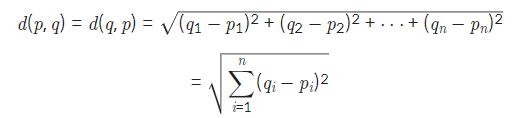

- 각 128차원의 벡터는 넘파이(Numpy)로 연산을 하기 위해서 리스트(list)에서 넘파이 배열(Numpy Array)로 변환
- 각 벡터간의 거리를 numpy.linalg.norm를 활용하여 L2 Norm Distance로 계산
- L2 Norm Distance는 위의 식처럼 각 차원의 차이를 제곱한 뒤 합한 후 제곱근을 구한 값입니다. 
- 2차원 유클리디안 거리를 다차원으로 확장시킨 것

In [11]:
distances = np.linalg.norm([A, B] - C, axis=1, ord=2)
print("Distance between A and C: {}".format(distances[0]))
print("Distance between B and C: {}".format(distances[1]))

Distance between A and C: 0.8211549091846528
Distance between B and C: 0.34743558135053815


위 계산 결과에서 볼 수 있듯이 같은 사람인 B와 C의 거리는 0.3474로 다른 사람 간의 거리(A와 C)인 0.8212보다 상대적으로 작은 것을 볼 수 있습니다. \
이렇게 임베딩으로 사람 얼굴을 비교하고 누가 같은 사람인지를 비교할 수 있다면 임베딩 벡터의 거리가 가까운 얼굴일수록 닮았다고 볼 수 있을 것

In [12]:
# L2 Distance가 아닌 L1 Distance로 계산한다면?
distances = np.linalg.norm([A, B] - C, axis=1, ord=1)
print("Distance between A and C: {}".format(distances[0]))
print("Distance between B and C: {}".format(distances[1]))

Distance between A and C: 7.720474720699713
Distance between B and C: 3.1546838842332363


- 전체적인 distance 값의 분포가 커진다

In [13]:
import numpy as np

x = np.array([1,2,3,4,5])
y = np.array([2,3,4,5,6])

print(np.linalg.norm(y-x, ord=1))  #L1 distance
print(np.linalg.norm(y-x, ord=2))  #L2 distance

5.0
2.23606797749979


In [14]:
def get_distance(name1, name2):
    return np.linalg.norm(embedding_dict[name1]-embedding_dict[name2], ord=2)

get_distance('obama', 'trump')

0.8885117374787042

- 먼저 PCA 는 주성분 분석이라는 방법으로 Principal Component Analysis 의 준말입니다. \
이 방법은 모든 차원의 축에 따른 값의 변화 도인 분산(Variance)을 확인한 뒤 그 중 변화가 가장 큰 주요한 축을 남기는 방법입니다.
- T-SNE 는 고차원 상에서 먼 거리를 저차원 상에서도 멀리 배치되도록 차원을 축소하는 방식입니다. \
먼저 random하게 목표하는 차원에 데이터들을 배치한 후 각 데이터들을 고차원 상에서의 배치와 비교를 하면서 위치를 변경해 주는 알고리즘으로 이해하시면 됩니다.

- PCA에서는 모든 차원이 잘 반영되지 않는 반면 T-SNE는 Iteration을 거칠수록 가까운 벡터들이 잘 군집한 형태로 차원 축소

In [15]:
def get_nearest_face(name, top=5): 
    pass
get_nearest_face('trump')

In [16]:
# name1과 name2의 거리를 비교하는 함수를 생성하되, name1은 미리 지정하고, name2는 호출시에 인자로 받도록 합니다.
def get_sort_key_func(name1):
    def get_distance_from_name1(name2):
        return get_distance(name1, name2)
    return get_distance_from_name1

sort_key_func = get_sort_key_func('trump')   
# 이렇게 생성된 함수 sort_key_func는 sort_key_func('obama') 라고 호출할 때 trump와 obama 사이의 임베딩 벡터 거리를 계산합니다.

In [17]:
sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))

[('trump',
  array([-0.15962467,  0.20268655,  0.0323635 ,  0.02439232, -0.06226439,
          0.05140705,  0.07351795, -0.16823348,  0.06962204, -0.05557961,
          0.17270109, -0.05094168, -0.35293093, -0.0316438 ,  0.03792984,
          0.17343847, -0.13260126, -0.15357377, -0.23523533, -0.08442692,
         -0.00134139,  0.03210667, -0.08926154, -0.02670781, -0.09581181,
         -0.25792354, -0.01056999, -0.11071672,  0.03133569, -0.07444921,
          0.05670552, -0.02273796, -0.19461137, -0.04576054,  0.00947582,
          0.01806056, -0.1502624 , -0.07787319,  0.17577608,  0.01933258,
         -0.19744575, -0.03930519,  0.07374467,  0.20196027,  0.1476755 ,
         -0.0141539 ,  0.0172476 , -0.11976205,  0.09462971, -0.24318144,
         -0.02755127,  0.12169892,  0.14837705,  0.17079785,  0.06952555,
         -0.15360466,  0.02005427,  0.08199155, -0.19544823,  0.10653654,
          0.11468476, -0.21902837, -0.07677591, -0.06791042,  0.10587606,
          0.05921567, -0.06

In [18]:
def get_nearest_face(name, top=5):
    sort_key_func = get_sort_key_func(name)
    sorted_faces = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))
    
    for i in range(top+1):
        if i == 0 :   # 첫번째로 나오는 이름은 자기 자신일 것이므로 제외합시다. 
            continue
        if sorted_faces[i]:
            print('순위 {} : 이름({}), 거리({})'.format(i, sorted_faces[i][0], sort_key_func(sorted_faces[i][0])))

In [19]:
# obama와 가장 닮은 사람은 누굴까요?
get_nearest_face('obama')

순위 1 : 이름(biden), 거리(0.846720652777963)
순위 2 : 이름(bush), 거리(0.8639189288560225)
순위 3 : 이름(reagan), 거리(0.8692435806803928)
순위 4 : 이름(trump), 거리(0.8885117374787042)
순위 5 : 이름(clinton), 거리(0.9000994624487408)


---

# 프로젝트 : 나랑 닮은 연예인을 찾아보자

- get_cropped_face(image_file) : 이미지 파일에서 얼굴 영역을 가져오는 함수
- get_face_embedding(face) : 얼굴영역으로부터 얼굴 임베딩 벡터를 구하는 함수
- get_face_embedding_dict(dir_path) : 디렉토리 안에 있는 모든 이미지의 임베딩 딕셔너리를 구하는 함수
- get_distance(name1, name2) : 두 이미지(사람 이름) 사이의 임베딩 벡터 거리를 구하는 함수

## Step1. 사진 모으기

### 1. 내 사진 찍기

- 1) 내 사진을 2장 이상 포함합시다.
- 2) 내 사진들끼리의 얼굴 임베딩 벡터 거리를 구해 봅시다. 닮았음을 확인할 수 있는 좋은 베이스라인이 될 수 있습니다.
- 3) 혹시 내 사진들끼리의 거리가 멀게 나온다면 왜 그럴지 생각해 봅시다.

In [20]:
# 내 사진끼리 얼굴 임베딩 벡터 거리 구해보기

In [150]:
import os

dir_path = os.getenv('HOME')+'/aiffel/face_embedding/my_image'
file_list = os.listdir(dir_path)
file_list.remove('.ipynb_checkpoints')

print ("file_list: {}".format(file_list))

file_list: ['sm3.jpg', 'sm1.jpg', 'sm2.jpg', 'sm4.jpg']


In [154]:
image_file = os.path.join(dir_path, 'sm1.jpg')
face = get_cropped_face(image_file)   # 얼굴 영역을 구하는 함수(이전 스텝에서 구현)
embedding = get_face_embedding(face) # 얼굴 영역으로부터 얼굴 임베딩 벡터 구하는 함수
embedding_dict = get_face_embedding_dict(dir_path) # 디렉토리 안에 있는 모든 이미지의 임베딩 딕셔너리를 구하는 함수
get_nearest_face('sm1', top=3) # 임베딩 벡터 거리를 구하는 함수

순위 1 : 이름(sm2), 거리(0.19345777819199186)
순위 2 : 이름(sm3), 거리(0.265595814602257)
순위 3 : 이름(sm4), 거리(0.28259703202388575)


내 사진들 사이의 거리는 실제로 매우 가깝게 나옴   
실제로 1번 사진과 2번 사진은 거의 같은 각도로 같은 시간대에 찍은 사진

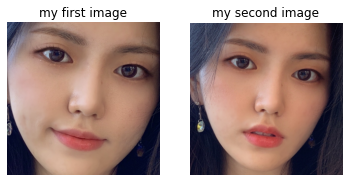

In [56]:
fig = plt.figure()

ax1 = fig.add_subplot(1, 2, 1)
image_file = os.path.join(dir_path, 'sm1.jpg')
face = get_cropped_face(image_file)
ax1.imshow(face)
ax1.set_title('my first image')
ax1.axis("off")

ax2 = fig.add_subplot(1, 2, 2)
image_file = os.path.join(dir_path, 'sm2.jpg')
face = get_cropped_face(image_file)
ax2.imshow(face)
ax2.set_title('my second image')
ax2.axis("off")

plt.show()

### 2. 비교할 연예인 사진 모으기

많이 모을수록 나와 더 닮은 연예인을 찾을 가능성이 높아질 것입니다.
주위의 동료들과 모은 사진을 주고받는 것도 하나의 방법입니다.

In [71]:
# 내 사진 폴더에 있는 연예인 사진 리스트 출력
image_path = os.getenv('HOME')+'/aiffel/face_embedding/celebrities'
celebritiy_list = os.listdir(image_path)
celebritiy_list.remove('.ipynb_checkpoints')

print ("file_list: {}".format(celebritiy_list))
print(len(celebritiy_list))

file_list: ['백현.jpg', '고윤정.jpg', '제니.jpg', '지수.jpg', '유리.jpg', '구하라.jpg', '박보영.jpg', '한가인.jpg', '서인국.jpg', '아이린.jpg', '문별.jpg', '모모.jpg', '오영주.jpg', '수지.jpg', '쯔위.jpg', '민효린.jpg', '아이유.jpg', '지드래곤.jpg', '서현진.jpg', '박재범.jpg', '지효.jpg', '다현.jpg', '웬디.jpg', '찬열.jpg', '김유정.jpg', '크리스탈.jpg', '사나.jpg', '츄.jpg', '윈터.jpg', '송중기.jpg', '서강준.jpg', '이종석.jpg', '김소현.jpg', '정연.jpg', '손나은.jpg', '김고은.jpg', '뷔.jpg', '최유정.jpg', '정채연.jpg', '김민석.jpg', '박보검.jpg', '안소희.jpg', '정재호.jpg', '시우민.jpg', '강민경.jpg', '디오.jpg', '카리나.jpg', '한소희.jpg', '세훈.jpg', '전소미.jpg', '윤아.jpg', '장기용.jpg', '정해인.jpg', '슬기.jpg', '설리.jpg', '태연.jpg', '티파니.jpg', '혜리.jpg', '김도연.jpg', '이주빈.jpg', '서현.jpg', '정은지.jpg']
62


## Step2. 얼굴 영역 자르기

In [164]:
# 1) 이미지 파일 경로를 파라미터로 넘기면 얼굴 영역만 잘라서 뿌려주는 함수
import face_recognition
import os
from PIL import Image

def get_cropped_face(image_file):
    image = face_recognition.load_image_file(image_file)
    face_locations = face_recognition.face_locations(image)
    a, b, c, d = face_locations[0]
    cropped_face = image[a:c,d:b,:]
    
    return cropped_face

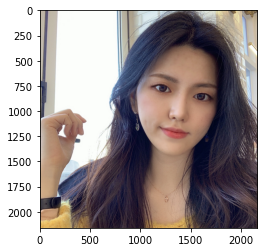

In [165]:
# 원본 이미지
image_path = os.getenv('HOME')+'/aiffel/face_embedding/my_image/sm1.jpg'
image = img.imread(image_path)
plt.imshow(image)

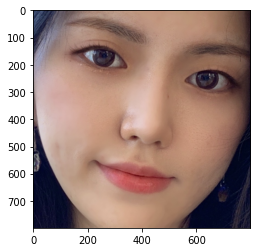

In [166]:
# 얼굴만 crop한 이미지
face = get_cropped_face(image_path)
plt.imshow(face)

In [160]:
# 위에서 크롭한 이미지를 저장해보자
from PIL import Image
cropped_path = os.getenv('HOME')+'/aiffel/face_embedding/cropped/'
pillow_image = Image.fromarray(face)
pillow_image.save(cropped_path + 'sm1_cropped.jpg')

In [200]:
# 테스트할 이미지들을 크롭하고 따로 저장해보자
dir_path = os.getenv('HOME')+'/aiffel/face_embedding/image'
path_list = os.listdir(dir_path)
path_list.remove('.ipynb_checkpoints')

from tqdm import tqdm
cropped_file_list = []
for i in tqdm(path_list):
    face = get_cropped_face(dir_path + '/' + i)
    pillow_image = Image.fromarray(face)
    image_cropped = os.path.join(cropped_path, i.split('.')[0] + '_cropped.jpg')
    cropped_file_list.append(i.split('.')[0] + '_cropped.jpg')
    pillow_image.save(image_cropped)

100%|██████████| 63/63 [00:33<00:00,  1.87it/s]


## Step3. 얼굴 영역의 임베딩 추출하기

In [206]:
embedding_dict = {}
for file in tqdm(cropped_file_list):
    img_path = os.path.join(cropped_path, file)
    face = face_recognition.load_image_file(img_path)
    embedding = get_face_embedding(face)
    if len(embedding) > 0:  
    # 얼굴영역 face가 제대로 detect되지 않으면  len(embedding)==0인 경우가 발생하므로 
    # os.path.splitext(file)[0]에는 이미지파일명에서 확장자를 제거한 이름이 담깁니다. 
        embedding_dict[os.path.splitext(file)[0]] = embedding[0]

100%|██████████| 63/63 [00:19<00:00,  3.24it/s]


## Step4. 모은 연예인들과 비교하기

In [208]:
# 첫 번째 사진 닮은 연예인
get_nearest_face('김수민1_cropped', top=5)

순위 1 : 이름(김수민2_cropped), 거리(0.19651519955625096)
순위 2 : 이름(김고은_cropped), 거리(0.3977364830264525)
순위 3 : 이름(지수_cropped), 거리(0.4032577776015266)
순위 4 : 이름(정연_cropped), 거리(0.41421278484287133)
순위 5 : 이름(유리_cropped), 거리(0.4216410288530622)


In [217]:
# 두 번째 사진 닮은 연예인
get_nearest_face('김수민2_cropped', top=5)

순위 1 : 이름(김수민1_cropped), 거리(0.19651519955625096)
순위 2 : 이름(김고은_cropped), 거리(0.36547866388882794)
순위 3 : 이름(아이유_cropped), 거리(0.3907633797016729)
순위 4 : 이름(유리_cropped), 거리(0.39078246427124264)
순위 5 : 이름(김유정_cropped), 거리(0.4026525900613637)


## Step5. 다양한 재미있는 시각화 시도해 보기

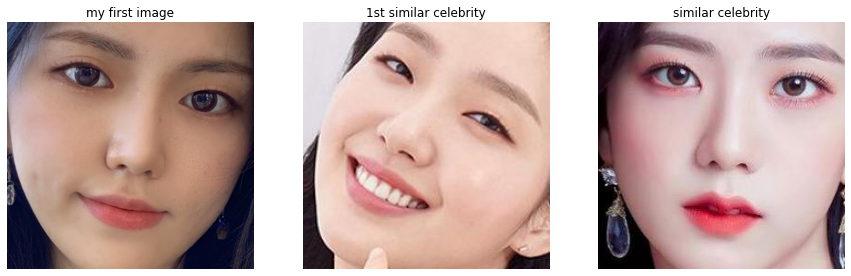

In [222]:
fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(1, 3, 1)
image_file = os.path.join(cropped_path, '김수민1_cropped.jpg')
face = face_recognition.load_image_file(image_file)
ax1.imshow(face)
ax1.set_title('my first image')
ax1.axis("off")

ax2 = fig.add_subplot(1, 3, 2)
image_file = os.path.join(cropped_path, '김고은_cropped.jpg')
face = face_recognition.load_image_file(image_file)
ax2.imshow(face)
ax2.set_title('1st similar celebrity')
ax2.axis("off")

ax3 = fig.add_subplot(1, 3, 3)
image_file = os.path.join(cropped_path, '지수_cropped.jpg')
face = face_recognition.load_image_file(image_file)
ax3.imshow(face)
ax3.set_title('similar celebrity')
ax3.axis("off")

plt.show()

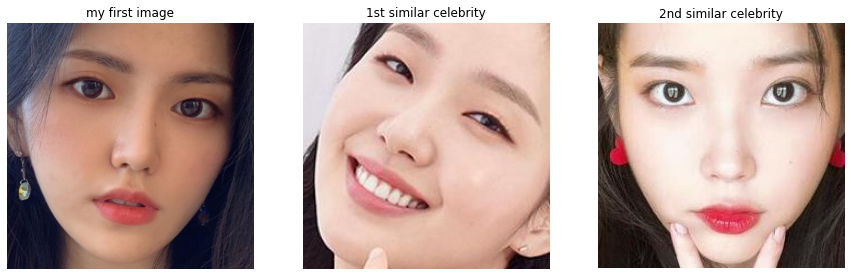

In [221]:
fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(1, 3, 1)
image_file = os.path.join(cropped_path, '김수민2_cropped.jpg')
face = face_recognition.load_image_file(image_file)
ax1.imshow(face)
ax1.set_title('my first image')
ax1.axis("off")

ax2 = fig.add_subplot(1, 3, 2)
image_file = os.path.join(cropped_path, '김고은_cropped.jpg')
face = face_recognition.load_image_file(image_file)
ax2.imshow(face)
ax2.set_title('1st similar celebrity')
ax2.axis("off")

ax3 = fig.add_subplot(1, 3, 3)
image_file = os.path.join(cropped_path, '아이유_cropped.jpg')
face = face_recognition.load_image_file(image_file)
ax3.imshow(face)
ax3.set_title('2nd similar celebrity')
ax3.axis("off")

plt.show()

- 내 사진 두 장에 대한 결과 모두 김고은이 가장 닮은 꼴 연예인으로 나왔다.
- 무쌍이라 이런 결과가 나온 것 같다.